# Lab 4: Nonlinear Regression

Task: Use `nn.Sequential` to add layers to a model; use a nonlinearity between layers to increase the model's capacity.

## Setup

In [21]:
from fastai.vision.all import *

This function will make a `DataLoaders` object out of an arary dataset.

In [22]:
def make_dataloaders(x, y_true, splitter, batch_size):
    data = L(zip(x, y_true))
    train_indices, valid_indices = splitter(data)
    return DataLoaders(
        DataLoader(data[train_indices], batch_size=batch_size, shuffle=True),
        DataLoader(data[valid_indices], batch_size=batch_size)
    )   

Here are utility functions to plot the first axis of a dataset and a model's predictions.

In [23]:
def plot_data(x, y): plt.scatter(x[:, 0], y[:, 0], s=.5, color='#bbbbbb')
def plot_model(x, model):
    x = x.sort(dim=0).values
    y_pred = model(x).detach()
    for output in range(y_pred.shape[1]):
        plt.plot(x[:, 0], y_pred[:, output], 'r')

The following `Callback` can be added to your `Learner` to plot the data and model after each epoch:

```
learner = Learner(
    ...
    cbs=[ShowPredictions(), ShowGraphCallback()],
    ...
```

In [24]:
# Inspired by https://gist.github.com/oguiza/c7559da6de0e036f01d7dee15e2f15e4
class ShowPredictions(Callback):
    def __init__(self): self.graph_fig = None # keep a reference to a figure object to update
    def before_fit(self):
        self.run = not hasattr(self.learn, 'lr_finder') and not hasattr(self, 'gather_preds')
    def after_fit(self): plt.close(self.graph_fig)
    def after_epoch(self):
        if self.graph_fig is None:
            self.graph_fig, self.graph_ax = plt.subplots(1)
            self.graph_out = display(self.graph_ax.figure, display_id=True)
        plt.sca(self.graph_ax)
        self.graph_ax.clear()
        # Plot code. Replace this if needed:
        plot_data(x, y_true)
        plot_model(x, self.model)
        # Update the graph.
        self.graph_out.update(self.graph_ax.figure)


## Task

Most applications of neural net models work in very high dimensions (e.g., each individual pixel in an image!) so it's hard to visualize what the model is actually learning. Here, we'll revisit the simple linear model that we looked at in Fundamentals `006` and `009`, which learned to predict a single continuous outcome variable `y` from a single continuous input feature `x`. So we can visualize the network's behavior just like any other univariate function: by plotting y vs x.

But this time the data isn't just a straight line; it's a fancy function of `x`.

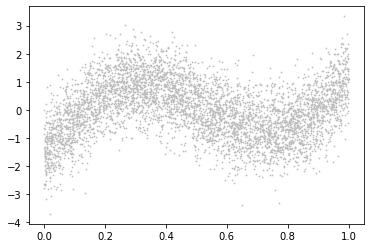

In [58]:
num_points = 5000

set_seed(42)
#x = torch.rand(num_points, 1)
noise = torch.randn_like(x) * .25
y_true = .5 * (x*6).sin() + x + noise
# standardize y, just to make it well behaved.
y_true -= y_true.mean()
y_true /= y_true.std()
plot_data(x, y_true)

In `006` and `009`, we dealt with models that could only ever make straight lines. They couldn't even make a curve like `3 * x**2 + 2*x + 1`, yet alone that one!

But you may remember from your math or stats studies that a curve like that is actually linear if you transform your data, e.g., using `z = [x, x**2]` as the input; then the model is `3 * z[1] + 2 * z[0] + 1`, which is linear in `z`.

So if we transform our data before giving it to the linear model, we can actually get interesting functions from a linear model. But how do we transform the data?

The classic approach is to specify what transformation to make. e.g., in *polynomial regression* we put in a bunch of powers of `x` (`x**2`, `x**3`, ..., `x**10`, ...), but that gets numerically unstable with high powers. There are other "basis functions" that are better behaved, like *splines*.

But neural nets take a different approach: they *learn* the transformation based on what is needed to accomplish its objective.

**Instructions**:

1. **Fit a line to this data** (minimizing the MSE). Evaluate the MSE. By eye, how well does it fit?
2. **Add a layer**: Use `nn.Sequential` to put two `nn.Linear` layers back to back. Use 500 dimensions as the hidden dimension (the `out_features` of the first and the `in_features` of the second). Evaluate the MSE. How well does it fit?
3. **Add a nonlinearity**: Add a `nn.ReLU` between the two linear layers. Evaluate the MSE. How well does it fit?

Details and tips are given inline below.

## Solution

**Make a `DataLoaders` for this data**. This step has been done for you. 

We increased the dataset size and the batch size to make the learning better-behaved. Once you get this to work, you might see if you can deal with a smaller batch size or less data overall.

In [26]:
splitter = RandomSplitter(valid_pct=0.2, seed=42)
batch_size = 100
dataloaders = make_dataloaders(x, y_true, splitter, batch_size=batch_size)

epoch,train_loss,valid_loss,mae,time
0,0.704555,0.525852,0.583871,00:00
1,0.448655,0.230320,0.379386,00:00
2,0.311613,0.183794,0.332062,00:00
3,0.246338,0.205163,0.366381,00:00
4,0.231951,0.228092,0.352074,00:00
5,0.211350,0.192988,0.316389,00:00
6,0.201556,0.190381,0.347240,00:00
7,0.207488,0.209763,0.353082,00:00
8,0.209624,0.230142,0.377817,00:00
9,0.211140,0.187710,0.322229,00:00


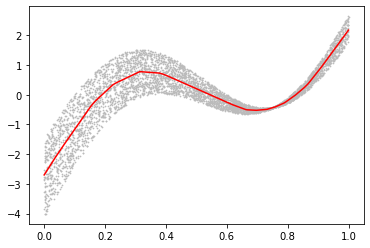

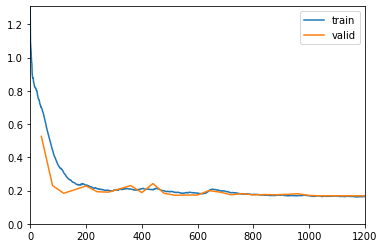

In [27]:
# set_seed(...)
set_seed(10)
model = nn.Sequential(
    nn.Linear(1, 500),
    nn.ReLU(),
    nn.Linear(500, 1)
)

loss_func = nn.MSELoss()


learner = Learner(
    dls=dataloaders,
    model=model,
    loss_func=loss_func,
    metrics=[mae],
    cbs=[ShowPredictions(), ShowGraphCallback()]
)
learner.fit_one_cycle(n_epoch=30, lr_max=.1)
# EOF


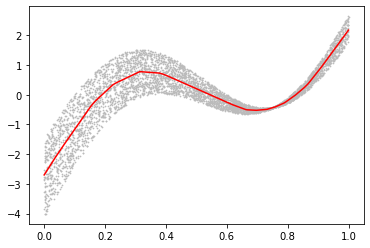

In [29]:
plot_data(x, y_true)
plot_model(x, model)
#plt.savefig('../../static/slides/w8/images/lab4-model.png')

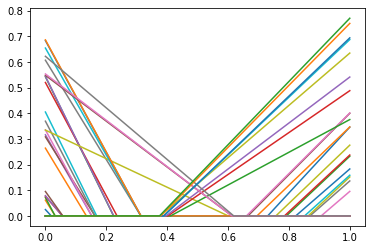

In [8]:
xsort = x.sort(dim=0).values
features = model[:2](xsort)
mags = features.sum(dim=0)
for idx in mags.sort().indices:
    if mags[idx] > 0:
        plt.plot(xsort, features[:, idx].detach())
#plt.savefig('../../static/slides/w8/images/lab4-features.png')

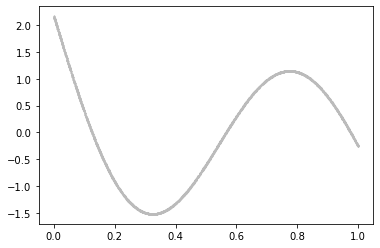

In [19]:
#set_seed(40)
torch.manual_seed(40)
#torch.rand(1)
#x = torch.rand(num_points, 1)
noise = torch.rand_like(x) * 1.
#noise = torch.rand_like(x) * 1.
y_true = -.5 * (x*6).sin() + -x + (x - .75) * noise
# standardize y, just to make it well behaved.
y_true -= y_true.mean()
y_true /= y_true.std()

plot_data(x, y_true)

In [13]:
import copy

In [14]:
model2 = copy.deepcopy(model)

In [15]:
splitter = RandomSplitter(valid_pct=0.2, seed=42)
batch_size = 100
dataloaders2 = make_dataloaders(x, y_true, splitter, batch_size=batch_size)

learner2 = Learner(
    dls=dataloaders2,
    model=model2,
    loss_func=loss_func,
    metrics=[mae],
    cbs=[ShowPredictions(), ShowGraphCallback()]
)
#learner2.fit_one_cycle(n_epoch=30, lr_max=.1)

In [16]:
learner2.freeze()

epoch,train_loss,valid_loss,mae,time
0,1.049191,0.359363,0.465277,00:00
1,0.485940,0.185375,0.327211,00:00
2,0.296495,0.182339,0.312754,00:00
3,0.224101,0.176019,0.301687,00:00
4,0.187580,0.172661,0.296061,00:00


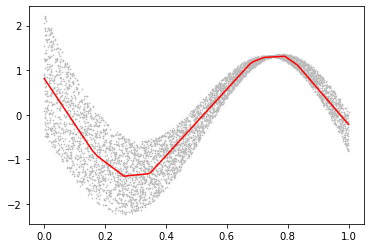

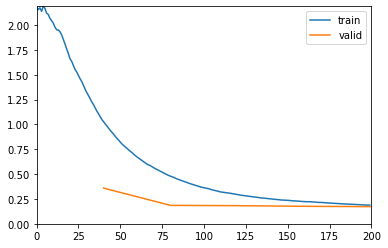

In [17]:
learner2.fit_one_cycle(n_epoch=5, lr_max=.1)

In [18]:
learner2.recorder.learn.model

Sequential(
  (0): Linear(in_features=1, out_features=500, bias=True)
  (1): ReLU()
  (2): Linear(in_features=500, out_features=1, bias=True)
)